<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [220]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
%matplotlib inline
import seaborn as sns

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [221]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-02-21 13:01:33--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.08s   

2020-02-21 13:01:34 (271 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [222]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [223]:
df.shape

(346, 10)

### Convert to date time object 

In [224]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [225]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [134]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         156 KB  anaconda

The following packages will be UPDATED:

    ca-certificates: 2019.11.28-hecc5488_0 conda-forge --> 2020.1.1-0        anaconda
    certifi:         2019.11.28-py36_0     conda-forge --> 2019.11.28-py36_0 anaconda
    openssl:         1.1.1d-h516909a_0     conda-forge --> 1.1.1-h7b6447c_0  anaconda


certifi-2019.11.28   | 156 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


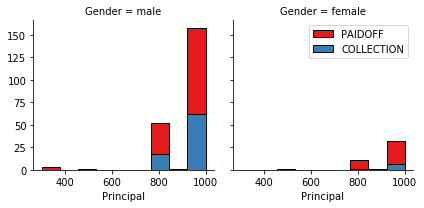

In [226]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

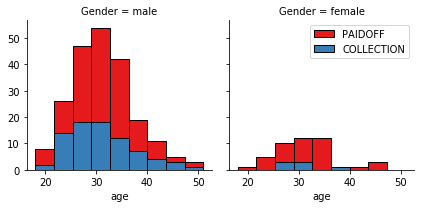

In [227]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

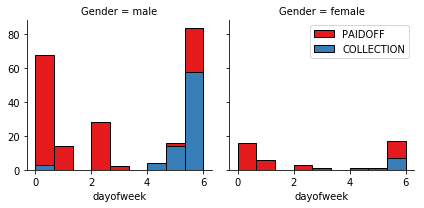

In [228]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [229]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [230]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [231]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [232]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [233]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [234]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [235]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [236]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [238]:
X= preprocessing.StandardScaler().fit(X.astype(float)).transform(X.astype(float))
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

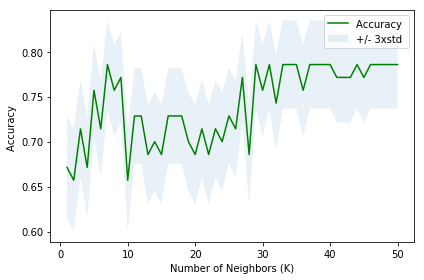

The best accuracy was with 0.7857142857142857 with k= 7


In [239]:
#splitting the dataset into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

#calculating the accuracy of KNN for different Ks
Ks = 51
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

plt.plot(range(1,51),mean_acc,'g')
plt.fill_between(range(1,51),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 
k=mean_acc.argmax()+1

In [240]:
#Train Model and Predict
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat_kmean = neigh.predict(X_test)

In [241]:
#calculating accuracy score
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_kmean))
print("F1-score: ",f1_score(y_test, yhat_kmean, average='weighted'))
print("Jaccard similarity score: ", jaccard_similarity_score(y_test, yhat_kmean))

Train set Accuracy:  0.8115942028985508
Test set Accuracy:  0.7857142857142857
F1-score:  0.7766540244416351
Jaccard similarity score:  0.7857142857142857


# Decision Tree

In [242]:
# Compare accuracy result for depth = 3, 4 and 5
d_range = range(3, 10)
f1 = []
ja = []
for d in d_range:
    DT = DecisionTreeClassifier(criterion="entropy", max_depth=d)
    DT.fit(X_train, y_train)
    dt_yhat = DT.predict(X_test)
    f1.append(f1_score(y_test, dt_yhat, average='weighted'))
    ja.append(jaccard_similarity_score(y_test, dt_yhat))

result = pd.DataFrame(f1, index=['d=3','d=4', 'd=5', 'd=6', 'd=7', 'd=8', 'd=9'])
result.columns = ['F1-score']
result.insert(loc=1, column='Jacard', value=ja)
result.columns.name = "Depth"
result

Depth,F1-score,Jacard
d=3,0.644599,0.614286
d=4,0.644599,0.614286
d=5,0.674185,0.642857
d=6,0.706479,0.771429
d=7,0.697881,0.757143
d=8,0.697881,0.757143
d=9,0.675824,0.657143


In [243]:
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
loanTree
loanTree.fit(X_train,y_train)

predTree = loanTree.predict(X_test)

In [244]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))
print("F1-score: ",f1_score(y_test, predTree, average='weighted'))
print("Jaccard similarity score: ", jaccard_similarity_score(y_test, predTree))

DecisionTrees's Accuracy:  0.7714285714285715
F1-score:  0.7064793130366899
Jaccard similarity score:  0.7714285714285715


# Support Vector Machine

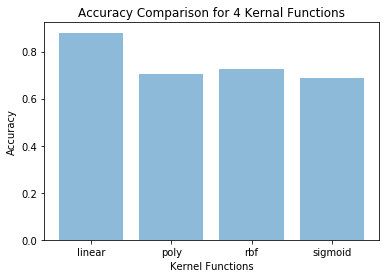

In [245]:
func_list = ['linear', 'poly', 'rbf', 'sigmoid']
accuracy_score = []
for func in func_list:
    SVM = svm.SVC(kernel=func, gamma="auto")
    SVM.fit(X_train, y_train)
    svm_yhat = SVM.predict(X_test)
    accuracy_score.append(f1_score(y_test, svm_yhat, average='weighted',labels=np.unique(svm_yhat)))

# plot the comparison among 4 kernel functions
y_pos = np.arange(len(func_list))
plt.bar(y_pos, accuracy_score, align='center', alpha=0.5)
plt.xticks(y_pos, func_list)
plt.ylabel('Accuracy')
plt.xlabel('Kernel Functions')
plt.title('Accuracy Comparison for 4 Kernal Functions')
plt.show()

In [246]:
clf = svm.SVC(kernel='rbf', gamma="auto")
clf.fit(X_train, y_train) 
yhat_svm = clf.predict(X_test)

In [247]:
print("SVM Accuracy: ", metrics.accuracy_score(y_test, yhat_svm))
print("F1-score: ",f1_score(y_test, yhat_svm, average='weighted') )
print("Jaccard similarity score: ",jaccard_similarity_score(y_test, yhat_svm))

SVM Accuracy:  0.7428571428571429
F1-score:  0.7275882012724117
Jaccard similarity score:  0.7428571428571429


# Logistic Regression

Test  0 : Accuracy at c = 0.1 solver= newton-cg is :  0.48275353245267294
Test  1 : Accuracy at c = 0.1 solver= lbfgs is :  0.4827539604894662
Test  2 : Accuracy at c = 0.1 solver= liblinear is :  0.4981902487744225
Test  3 : Accuracy at c = 0.1 solver= sag is :  0.48275447991659615
Test  4 : Accuracy at c = 0.1 solver= saga is :  0.48274730473947236
Test  5 : Accuracy at c = 0.01 solver= newton-cg is :  0.492017801467927
Test  6 : Accuracy at c = 0.01 solver= lbfgs is :  0.4920179847937498
Test  7 : Accuracy at c = 0.01 solver= liblinear is :  0.5772287609479654
Test  8 : Accuracy at c = 0.01 solver= sag is :  0.4920097320739775
Test  9 : Accuracy at c = 0.01 solver= saga is :  0.49201769336158785
Test  10 : Accuracy at c = 0.001 solver= newton-cg is :  0.5181765961927621
Test  11 : Accuracy at c = 0.001 solver= lbfgs is :  0.5181766145124602
Test  12 : Accuracy at c = 0.001 solver= liblinear is :  0.670867975563743
Test  13 : Accuracy at c = 0.001 solver= sag is :  0.5181784545054088

Text(0, 0.5, 'Testing Accuracy')

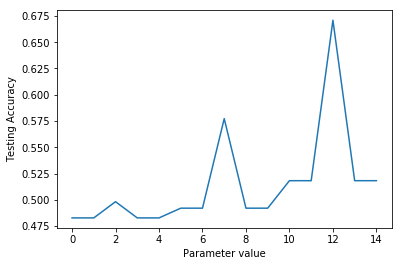

In [248]:
c_list = [0.1, 0.01, 0.001]
solver_list = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
idx = []
accuracy_score = []
for idx1, c in enumerate(c_list):
    for idx2, sol in enumerate(solver_list):
        idx.append(idx2 + idx1 * 5)
        # perform the test
        LR = LogisticRegression(C=c, solver=sol).fit(X_train, y_train)
        # it can predict the outcome
        lr_yhat = LR.predict(X_test)
        lr_prob = LR.predict_proba(X_test)
        print("Test ", (idx2 + idx1 * 5), ": Accuracy at c =", c,"solver=", sol,"is : ", log_loss(y_test, lr_prob))
        accuracy_score.append(log_loss(y_test, lr_prob))
        lr_prob = LR.predict_proba(X_test)
        log_loss(y_test, lr_prob)
# plot the relationship between K and testing accuracy\n",
plt.plot(idx, accuracy_score)
plt.xlabel('Parameter value')
plt.ylabel('Testing Accuracy')

In [249]:
LR = LogisticRegression(C=0.001, solver='liblinear').fit(X_train,y_train)
yhat_logistic = LR.predict(X_test)

yhat_prob = LR.predict_proba(X_test)

In [250]:
print("Logistic Accuracy: ", metrics.accuracy_score(y_test, yhat_logistic))
print("F1-score: ",f1_score(y_test, yhat_logistic, average='weighted') )
print("Jaccard similarity score: ",jaccard_similarity_score(y_test, yhat_logistic))
print("Log loss: ",log_loss(y_test, yhat_prob))

Logistic Accuracy:  0.6714285714285714
F1-score:  0.6752209022111361
Jaccard similarity score:  0.6714285714285714
Log loss:  0.670867975563743


# Model Evaluation using Test set

In [251]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [252]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-02-21 13:03:02--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-02-21 13:03:03 (389 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [253]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [254]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [255]:
Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
Feature_test.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [256]:
X_loan_test = Feature_test
X_loan_test = preprocessing.StandardScaler().fit(X_loan_test.astype(float)).transform(X_loan_test.astype(float))

y_loan_test = test_df['loan_status'].values

In [257]:
#k mean classification
yhat_kmean_test = neigh.predict(X_loan_test)
print("Test set Accuracy: ", metrics.accuracy_score(y_loan_test, yhat_kmean_test))
fs1=round(f1_score(y_loan_test, yhat_kmean_test, average='weighted',labels=np.unique(yhat_kmean_test)),2)
js1=round(jaccard_similarity_score(y_loan_test, yhat_kmean_test),2)

Test set Accuracy:  0.6666666666666666


In [258]:
#decison tree classification
predTree_test = loanTree.predict(X_loan_test)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_loan_test, predTree_test))
fs2=round(f1_score(y_loan_test, predTree_test, average='weighted',labels=np.unique(predTree_test)),2)
js2=round(jaccard_similarity_score(y_loan_test, predTree_test),2)

DecisionTrees's Accuracy:  0.7222222222222222


In [259]:
#Support vector machine classification
yhat_svm_test = clf.predict(X_loan_test)
print("SVM Accuracy: ", metrics.accuracy_score(y_loan_test, yhat_svm_test))
fs3=round(f1_score(y_loan_test, yhat_svm_test, average='weighted',labels=np.unique(yhat_svm_test)) ,2)
js3=round(jaccard_similarity_score(y_loan_test, yhat_svm_test),2)

SVM Accuracy:  0.7962962962962963


In [260]:
#Logistic classification
yhat_logistic_test = LR.predict(X_loan_test)

yhat_prob_test = LR.predict_proba(X_loan_test)

print("Logistic Accuracy: ", metrics.accuracy_score(y_loan_test, yhat_logistic_test))
fs4=round(f1_score(y_loan_test, yhat_logistic_test, average='weighted',labels=np.unique(yhat_logistic_test)) ,2)
js4=round(jaccard_similarity_score(y_loan_test, yhat_logistic_test),2)
ll=round(log_loss(y_loan_test, yhat_prob_test),2)

Logistic Accuracy:  0.7407407407407407


In [261]:
list_fs = [fs1, fs2, fs3, fs4]
print(list_fs)
list_js = [js1, js2, js3, js4]
print(list_js)
list_ll = ['NA', 'NA', 'NA', ll]
print(list_ll)

[0.63, 0.67, 0.76, 0.7]
[0.67, 0.72, 0.8, 0.74]
['NA', 'NA', 'NA', 0.67]


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

In [262]:
df = pd.DataFrame(list_js, index=['KNN','Decision Tree','SVM','Logistic Regression'])
df.columns = ['Jaccard']
df.insert(loc=1, column='F1-score', value=list_fs)
df.insert(loc=2, column='LogLoss', value=list_ll)
df.columns.name = 'Algorithm'
df

Algorithm,Jaccard,F1-score,LogLoss
KNN,0.67,0.63,NA
Decision Tree,0.72,0.67,NA
SVM,0.80,0.76,NA
Logistic Regression,0.74,0.70,0.67


| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>